In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os 

In [75]:
files = os.listdir()
files = [file for file in files if file.endswith('.csv')]

result_frame = []
counter = 0

for file in files:
    no_prefix = file.removeprefix('dice_scores_')
    experiment = no_prefix.split('_')[0]
    exp_nr = int(experiment[3])
    if exp_nr == 1:
        continue
    rotated = (experiment[4] == 'b')

    df = pd.read_csv(file)

    df['Rotated'] = [rotated for _ in range(len(df))]
    df['Experiment'] = [exp_nr for _ in range(len(df))]

    dataset_codes = ['0007', '0018', '0020', '0021', '0023']
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean([df.loc[i, c] for c in dataset_codes if df.loc[i, c] > 0]))

    df['Score'] = scores 

    result_frame.append(df)

result_frame = pd.concat(result_frame)

/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jessebrouwers/miniconda3/envs/DL2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jessebrouwers/miniconda3/envs/DL2/l

In [76]:
result_frame

,Organ,0007,0018,0020,0021,0023,Rotated,Experiment,Score
0,Aorta,0.187852,0.000000,0.0,0.0,0.000000,False,3,0.187852
1,Colon cancer,0.000000,0.202987,0.0,0.0,0.000000,False,3,0.202987
2,Esophagus,0.299166,0.000000,0.0,0.0,0.000000,False,3,0.299166
3,Gallbladder,0.144263,0.000000,0.0,0.0,0.000000,False,3,0.144263
4,Inferior vena cava,0.218966,0.000000,0.0,0.0,0.000000,False,3,0.218966
...,...,...,...,...,...,...,...,...,...
11,Portal/splenic vein,0.087782,0.000000,0.0,0.0,0.000000,True,5,0.087782
12,Right adrenal gland,0.129439,0.000000,0.0,0.0,0.000000,True,5,0.129439
13,Right kidney,0.299800,0.000000,0.0,0.0,0.000000,True,5,0.299800
14,Spleen,0.253204,0.000000,0.0,0.0,0.361439,True,5,0.307322


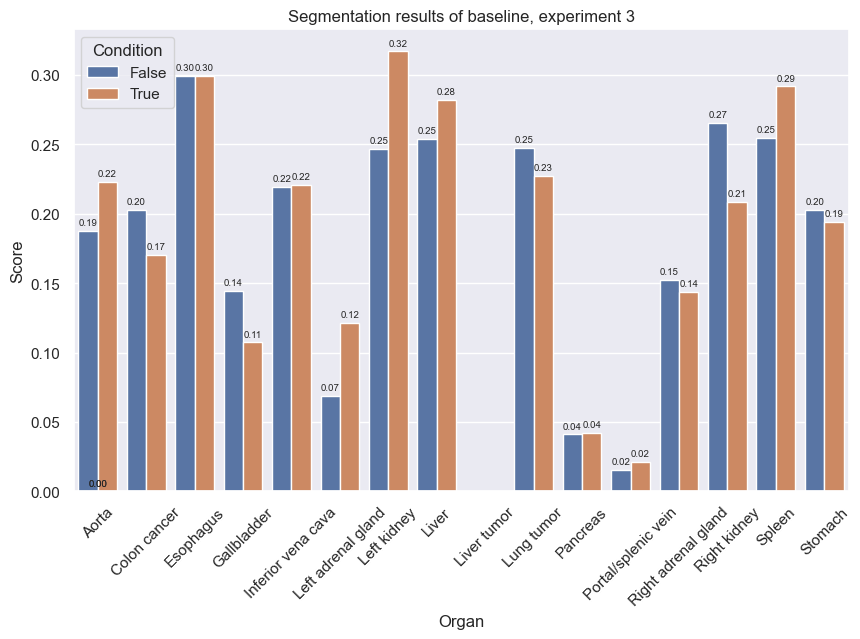

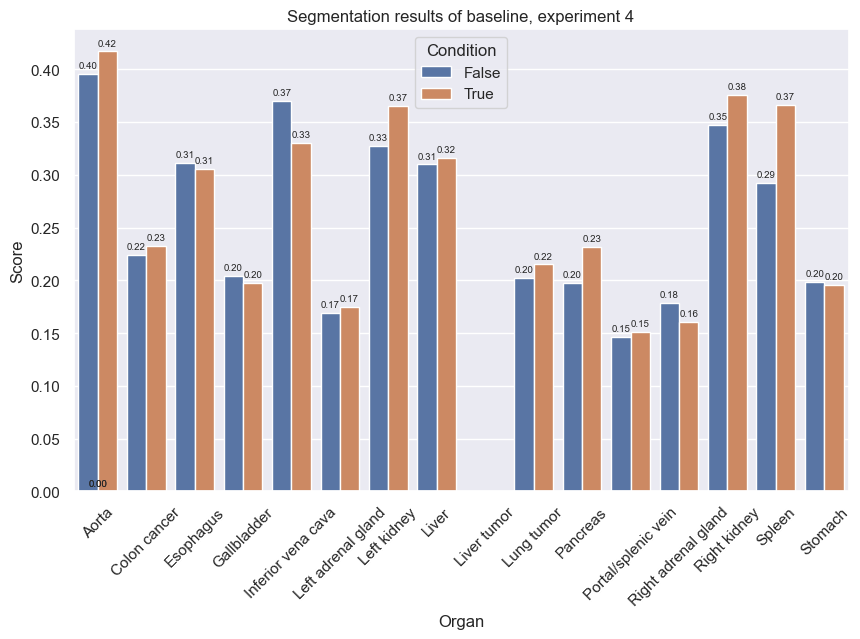

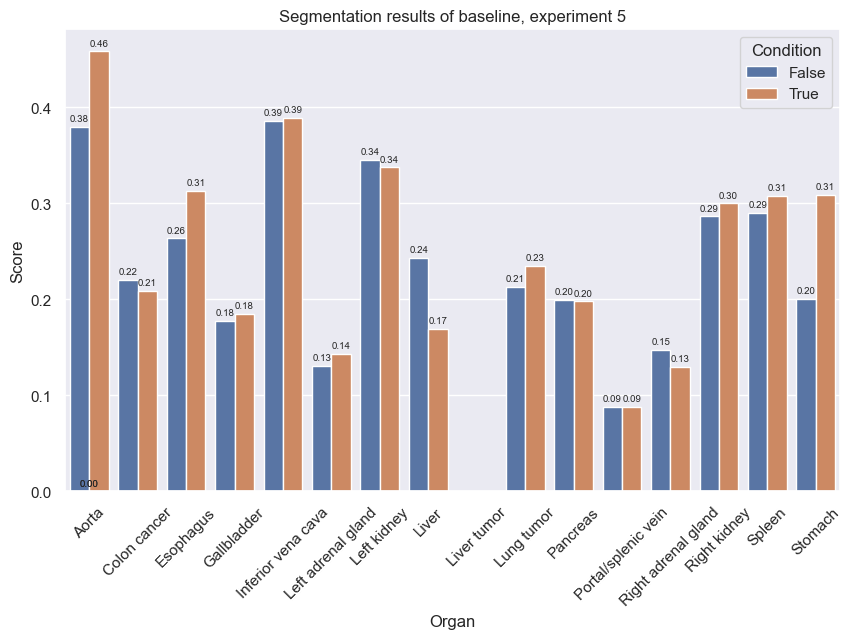

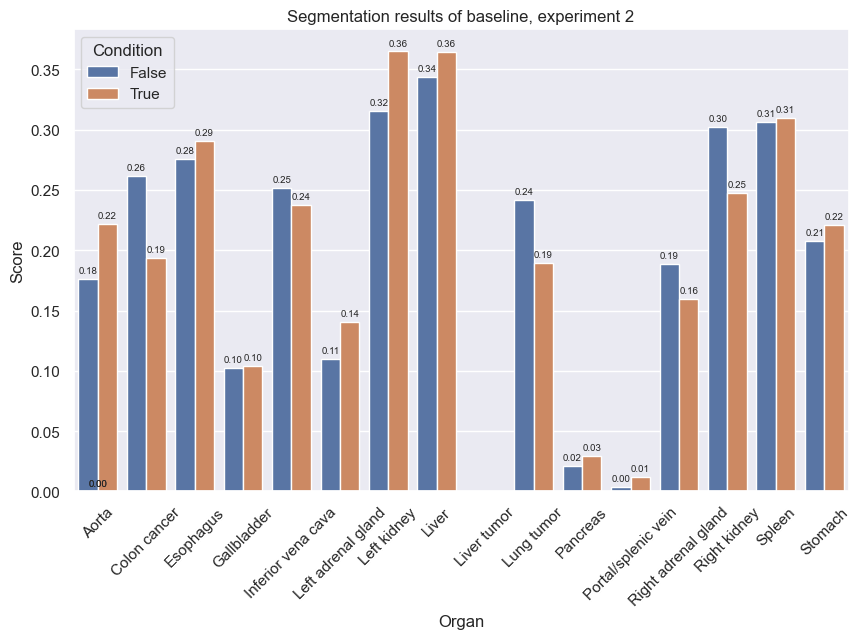

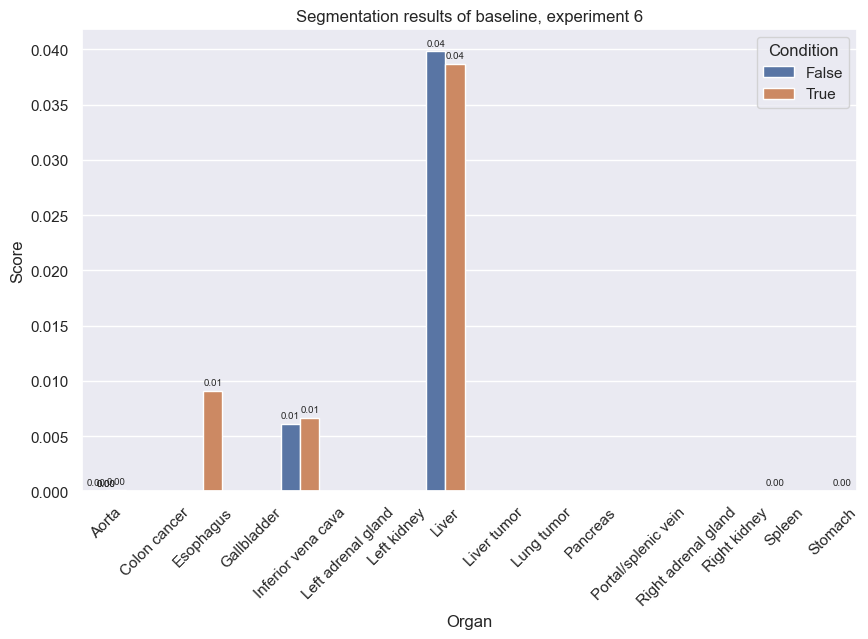

In [77]:
for experiment in result_frame['Experiment'].unique():
    subset = result_frame[result_frame['Experiment'] == experiment].copy()
    subset = subset.reset_index()

    sns.set_theme()
    plt.figure(figsize=(10, 6))
    plot = sns.barplot(x='Organ', y='Score', hue='Rotated', data=subset)
    plt.xticks(rotation=45)
    plt.legend(title=f'Rotated', loc='upper right')
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 6), 
                    textcoords = 'offset points',
                    fontsize=7)
    plt.title(f'Segmentation results of baseline, experiment {experiment}')
    plt.xlabel('Organ')
    plt.ylabel('Score')
    plt.legend(title='Condition')
    plt.show()
    